<h1><center>Breathe Blue</center></h1>
<h2><center>IEEE's The Blue Sky Challenge</center></h2>

### Introduction

A number of factors in the air can have an impact on its quality. The role of temperature  and carbon monoxide in air quality is vital. The following issue that may be addressed in order to make such systems smarter:

<b>Temporal forecasting of temperature and Carbon Monoxide (CO)</b> sensor data one day ahead: It can assist the general public and government officials in anticipating trends early in order to make timely decisions and take preventative actions. This "Breathe Blue" model is made for predicting values for a given week with just it's previous week's data.

### Installing necessary packages

Please comment this code after first installation (Add '#' in the start)

In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### Importing Libraries 

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn import metrics
warnings.filterwarnings("ignore")

### Analysing the Data

In [3]:
#Eliminating the delimiters while importing
dataset=pd.read_csv('AirQuality.csv', sep=";") 
df=dataset.copy()
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


### Trimming to the required columns and rows
<b>Initial Training Data Period</b>: 7 days from 11/03/2004 00.00.00 to 17/03/2004 23.00.00

<b>Testing Data Period</b>:          7 days from 18/03/2004 00.00.00 to 24/03/2004 23.00.00

Each day of the training and test data period have 24 data points starting from 00.00.00 to 23.00.00.

In [4]:
#Trimming the Dataset from 11/03/2004 to 24/03/2004
df.Date = pd.to_datetime(df.Date, format='%d/%m/%Y')
df=df[(df.Date >= '2004-03-11' ) & (df.Date < '2004-03-25')]

#Trimming the Dataset to the required columns
df1=df[['Date','Time','CO(GT)','T']];
df1.head()

,Date,Time,CO(GT),T
6,2004-03-11,00.00.00,"1,2","11,3"
7,2004-03-11,01.00.00,1,"10,7"
8,2004-03-11,02.00.00,"0,9","10,7"
9,2004-03-11,03.00.00,"0,6","10,3"
10,2004-03-11,04.00.00,-200,"10,1"


In [5]:
df1.shape 

(336, 4)

### Cleaning the Dataset

The whole format of date and time complicates the prediction, instead just the day and hour are extracted

In [6]:
df1['Day']= df1['Date'].dt.day 
df1['Hour']=df1['Time'].apply(lambda x: int(x.split('.')[0]))
df1.head()

,Date,Time,CO(GT),T,Day,Hour
6,2004-03-11,00.00.00,"1,2","11,3",11,0
7,2004-03-11,01.00.00,1,"10,7",11,1
8,2004-03-11,02.00.00,"0,9","10,7",11,2
9,2004-03-11,03.00.00,"0,6","10,3",11,3
10,2004-03-11,04.00.00,-200,"10,1",11,4


Notice that CO concentration and Temperature have error in their entries. Correcting them:

In [7]:
df1["CO(GT)"]=(df1["CO(GT)"].str.replace(',','.')).astype(float)
df1["T"]=(df1["T"].str.replace(',','.')).astype(float)

Checking if there are any nan values

In [8]:
df1.isnull().sum()

Date      0
Time      0
CO(GT)    0
T         0
Day       0
Hour      0
dtype: int64

Notice that there are negative values(-200) in concentration of CO. Dropping them and also resetting the row indices

In [9]:
#Backup for future analysis and improvement
dfs = df1

index = df1[ (df1["CO(GT)"] < 0)].index
df1.drop(index, inplace=True)
df1= df1.reset_index(drop=True)

### Visualisation of Data

#### CO Concentration(mg/m3) variation - Each Color representing a day

<function matplotlib.pyplot.autoscale(enable=True, axis='both', tight=None)>

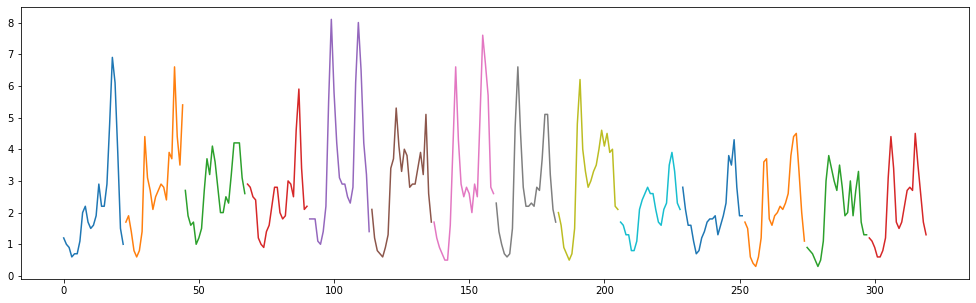

In [10]:
df1.groupby('Day')['CO(GT)'].plot(figsize=(17,5))
plt.autoscale

#### CO Concentration every hour w.r.t to each given day

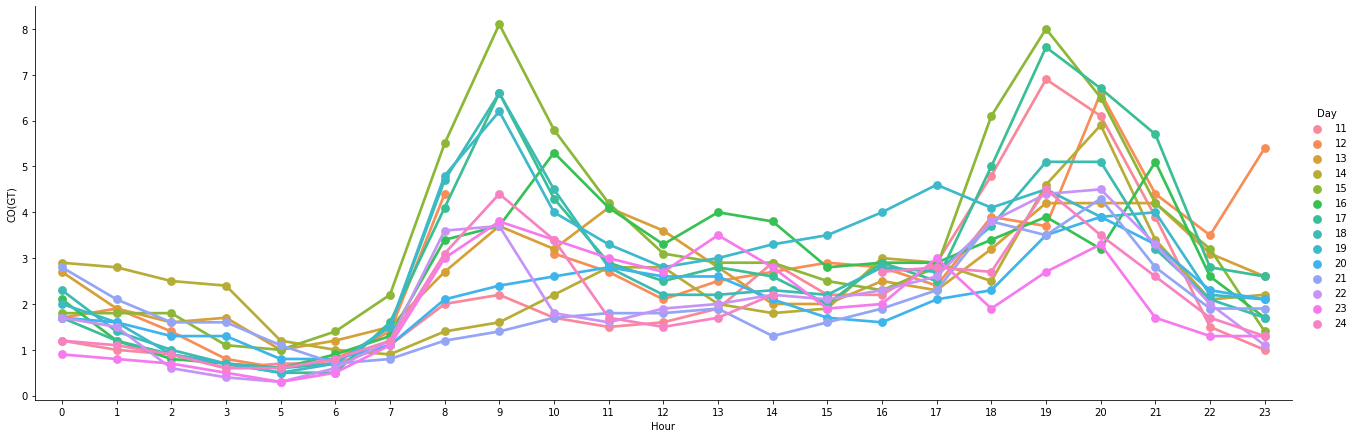

In [11]:
sns.catplot(x="Hour", y="CO(GT)", hue='Day', data=df1, kind='point', height=6, aspect=3)

#### Temperature(Celsius) Variation - Each Color representing a day

<function matplotlib.pyplot.autoscale(enable=True, axis='both', tight=None)>

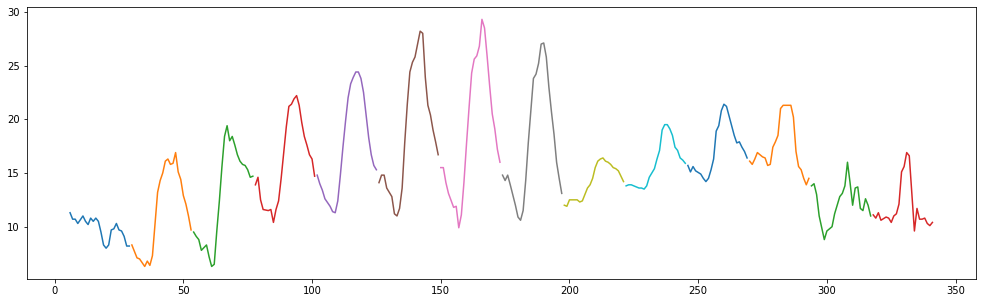

In [12]:
dfs.groupby('Day')['T'].plot(figsize=(17,5))
plt.autoscale

#### Temperature every hour w.r.t to each given day

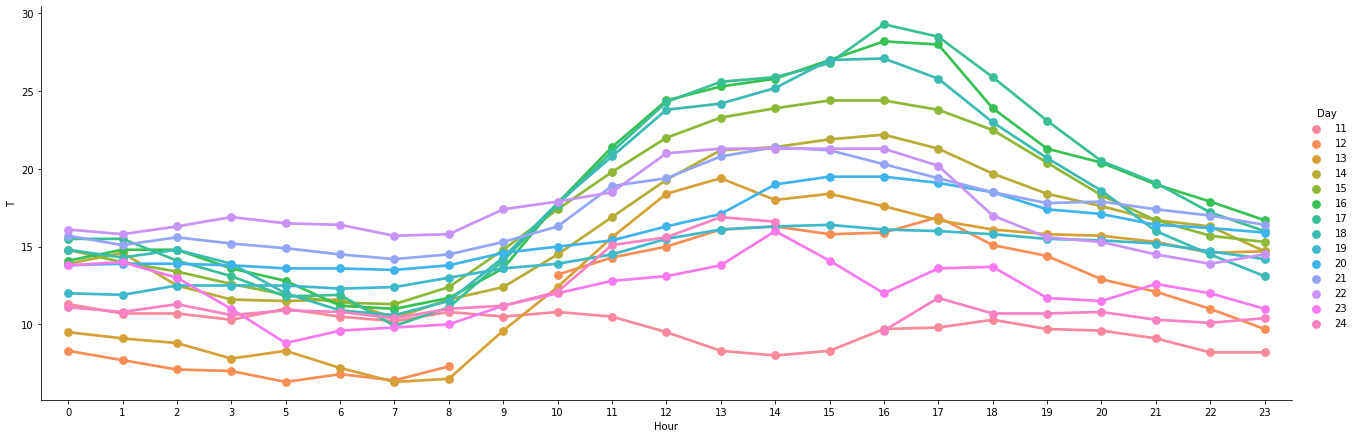

In [13]:
sns.catplot(x="Hour", y="T", hue='Day', data=df1, kind='point', height=6, aspect=3)

### Train-Test Spliting

Initially, train the machine learning model using 7 days data from 11/03/2004 00.00.00 to 17/03/2004 23.00.00.

Perform temporal forecasting (one-day ahead forecasting) for the 8th day using 7 days of data. Compare the forecast values with the real sensor data and perform performance evaluation using the metrics Mean Absolute Percentage Error (MAPE). <b>Perform the temporal forecasting for the 9th day by updating the training database from the 8th day sensor measurements</b>. Compute the forecasting performance metric and follow the same procedure for the rest.

In [14]:
X_1, X_2 = df1[(mask:=df1['Day'] <= 17)].copy(), df1[~mask].copy()

c = X_1.columns.tolist()[2:]
Train = X_1[c]
Test = X_2[c]

Train.reset_index(drop=True,inplace=True)
Test.reset_index(drop=True,inplace=True)


Seperating the dependent(target values) and independent columns

In [15]:
x_train = Train.drop(['CO(GT)', 'T'],axis=1)
x_test =  Test.drop(['CO(GT)', 'T'],axis=1)

y_test =  Test[['CO(GT)','T']]
y_train = Train[['CO(GT)','T']]

### Model Implementation 

In [16]:
import xgboost as xgb

#### Listing out possible range of the Regressor's paramaters

In [17]:
params={
 "estimator__learning_rate"    : [ 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.50 ] ,
 "estimator__max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15, 20, 25],
 "estimator__min_child_weight" : [ 1, 3, 5, 7, 10 ],
 "estimator__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5],
 "estimator__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7, 0.9 ]
}

#### Hyperparameter tuning using RandomizedSearch CV

Providing the XGBRegressor inside a MultiOutput Regressor since we are predicting both T and CO(GT) together

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
Regressor=MultiOutputRegressor(xgb.XGBRegressor())
random_search=RandomizedSearchCV(Regressor,param_distributions=params,n_iter=20,scoring='roc_auc',n_jobs=-1,cv=5,verbose=3)
random_search.fit(x_train,y_train)
random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5,
                                            enable_categorical=False, gamma=0.4,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.25,
                                            max_delta_step=None, max_depth=10,
                                            min_child_weight=7, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=No

#### Fitting and Predicting
Passing the Regressor with the best paramters into a <i>for loop</i>, that iterates and predicts for the 18th day, takes the real values of 18th day and pushes into the training dataset to predict the next day and continue the process. 

In [19]:
UV = x_test['Day'].unique()
temp = 0;
result =[]
f=0;
for i in UV:
    model1 = MultiOutputRegressor(xgb.XGBRegressor(base_score=None, booster=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7,
                                            enable_categorical=False, gamma=0.3,
                                            gpu_id=None, importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.3,
                                            max_delta_step=None, max_depth=10,
                                            min_child_weight=1,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None,
                                            reg_alpha=None, reg_lambda=None,
                                            scale_pos_weight=None,
                                            subsample=None, tree_method=None,
                                            validate_parameters=None,
                                            verbosity=None))
    model1.fit(x_train,y_train)
    testx = x_test[x_test["Day"] == i]
    testy = y_test[temp:temp+len(testx)]
    test1 = testx.to_numpy()
    x_train = x_train.append(testx, ignore_index=True)
    y_train = y_train.append(testy, ignore_index=True)
    resultx = model1.predict(test1)
    result.append(resultx)
    temp += len(testx)
    print('\nPredicted array of values of the %dth day\n' %(18+f), result[f])
    f=f+1;


Predicted array of values of the 18th day
 [[ 2.1103256 16.177864 ]
 [ 1.9194418 16.09824  ]
 [ 1.6471273 15.417482 ]
 [ 1.3936915 14.642238 ]
 [ 1.2087159 14.319855 ]
 [ 1.2087159 13.919968 ]
 [ 1.642653  13.403366 ]
 [ 3.5604608 14.006867 ]
 [ 4.2778187 15.708034 ]
 [ 3.8092098 18.587807 ]
 [ 3.3474078 20.89564  ]
 [ 2.885692  22.764547 ]
 [ 2.885692  23.637913 ]
 [ 2.885692  23.637913 ]
 [ 2.750143  24.093891 ]
 [ 2.8421853 24.531734 ]
 [ 2.8421853 24.438896 ]
 [ 4.3082304 22.797989 ]
 [ 5.6160307 21.446066 ]
 [ 5.6160307 20.079597 ]
 [ 4.5769515 19.187767 ]
 [ 2.8520048 18.223862 ]
 [ 2.6928227 17.516365 ]]

Predicted array of values of the 19th day
 [[ 1.9000056  15.191443  ]
 [ 1.6159581  15.092712  ]
 [ 1.3275661  14.56211   ]
 [ 1.0821755  13.738068  ]
 [ 0.91926235 13.256382  ]
 [ 0.91926235 12.743152  ]
 [ 1.402014   12.219635  ]
 [ 3.4798634  12.880301  ]
 [ 4.3627267  14.701357  ]
 [ 3.668162   17.721258  ]
 [ 3.0571685  20.074114  ]
 [ 2.6053123  22.092417  ]
 [ 2.6053123

### Calculating the MAPE

Using the formula, MAPE = Mean(abs((Actual-Predicted)/Actual)) for each day for both CO and T 

In [20]:
MAPEt=[]
MAPEc=[]
predicted_c = []
predicted_t = []
y_array = y_test.to_numpy()
temp=0
for j in result:
    for i in j:
        predicted_c.append(i[0])
        predicted_t.append(i[1])
    test2 = y_array[temp:temp+len(j)]
    error = abs((test2-j)/test2)
    cerror = error.mean(axis = 0)
    MAPEc.append(cerror[0])
    MAPEt.append(cerror[1])
    temp += len(j)

#### Daywise-MAPE of CO Concentration and Temperature

In [21]:
for i in range(0,len(MAPEc)):
    print("MAPE of CO Conc. in %dth day: %s" % ((i+18),MAPEc[i]))

MAPE of CO Conc. in 18th day: 0.3394020577718969
MAPE of CO Conc. in 19th day: 0.23537511969639524
MAPE of CO Conc. in 20th day: 0.38055520461690046
MAPE of CO Conc. in 21th day: 0.42990763990019415
MAPE of CO Conc. in 22th day: 0.2128026632160354
MAPE of CO Conc. in 23th day: 0.3310908610541785
MAPE of CO Conc. in 24th day: 0.20915217084953647


In [22]:
for i in range(0,len(MAPEt)):
    print("MAPE of T in %dth day: %s" % ((i+18),MAPEt[i]))

MAPE of T in 18th day: 0.11806801788399722
MAPE of T in 19th day: 0.25201352976406255
MAPE of T in 20th day: 0.1425698664991337
MAPE of T in 21th day: 0.1090814752619842
MAPE of T in 22th day: 0.12647537943125992
MAPE of T in 23th day: 0.42052674701332565
MAPE of T in 24th day: 0.18724052801552765


#### Average MAPE of CO Concentration and Temperature

In [23]:
print('Average MAPE of CO Concentration', np.mean(MAPEc))

Average MAPE of CO Concentration 0.3054693881578768


In [24]:
print('Average MAPE of T Concentration', np.mean(MAPEt))

Average MAPE of T Concentration 0.19371079198132726


### Analysing the Predicted Values

In [25]:
df2 = Test;
first_column = df2.pop('Day')
second_column = df2.pop('Hour')  
df2.insert(0, 'Day', first_column)
df2.insert(1, 'Hour', second_column)
pd.set_option('display.colheader_justify', 'center')

df2['CO(GT) Predicted'] = predicted_c
df2['T Predicted'] = predicted_t
df2['CO(GT) Error'] = (df2['CO(GT) Predicted']-df2['CO(GT)'])
df2['T Error'] = (df2['T Predicted']-df2['T'])

In [26]:
df2.head()

,Day,Hour,CO(GT),T,CO(GT) Predicted,T Predicted,CO(GT) Error,T Error
0,18,0,2.3,14.8,2.110326,16.177864,-0.189674,1.377864
1,18,1,1.4,14.3,1.919442,16.098240,0.519442,1.798240
2,18,2,1.0,14.8,1.647127,15.417482,0.647127,0.617482
3,18,3,0.7,13.9,1.393692,14.642238,0.693692,0.742238
4,18,5,0.6,12.0,1.208716,14.319855,0.608716,2.319855


#### Visual Representation of Day-wise CO Concentration  (Actual vs Predicted)

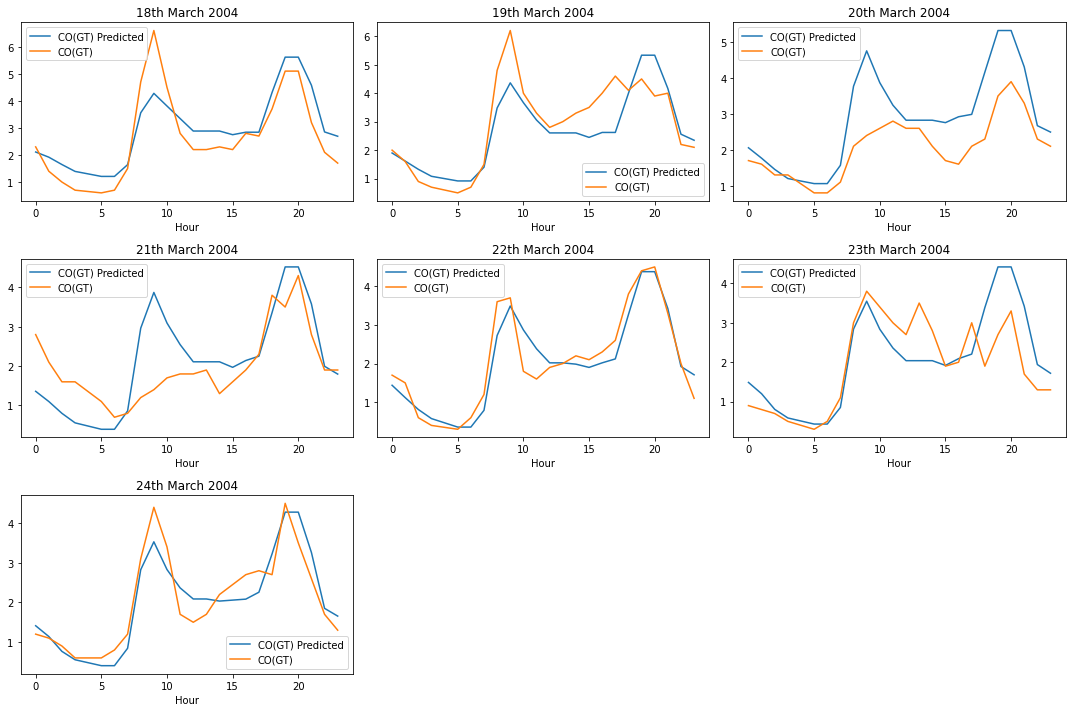

In [27]:
fig = plt.figure(figsize=(15, 10))
for i in range(0,7):
    ax = fig.add_subplot(3,3,i+1)
    df2[df2['Day']==18+i].plot('Hour',['CO(GT) Predicted','CO(GT)'],ax=ax)
    plt.title('%dth March 2004' % (18+i))
    plt.tight_layout()

#### Visual Representation of Day-wise Temperature values  (Actual vs Predicted)

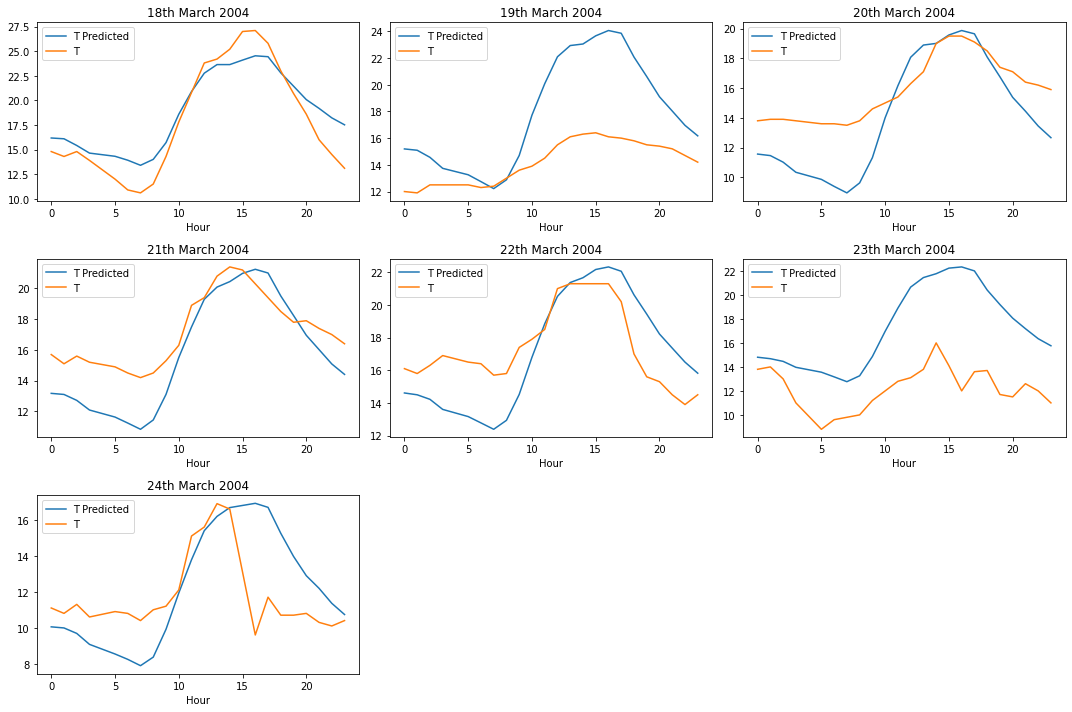

In [28]:
fig = plt.figure(figsize=(15, 10))
for i in range(0,7):
    ax = fig.add_subplot(3,3,i+1)
    df2[df2['Day']==18+i].plot('Hour',['T Predicted','T'],ax=ax)
    plt.title('%dth March 2004' % (18+i))
    plt.tight_layout()

<b>As the result above doesn't give a satisfactory output, especially the Temperature. We will now analyse and understand the stability of the dataset</b>

_______________________________________________________________________________
## Decomposition of variations in Temperature

Let's bring back this graph and observe the variations 

<function matplotlib.pyplot.autoscale(enable=True, axis='both', tight=None)>

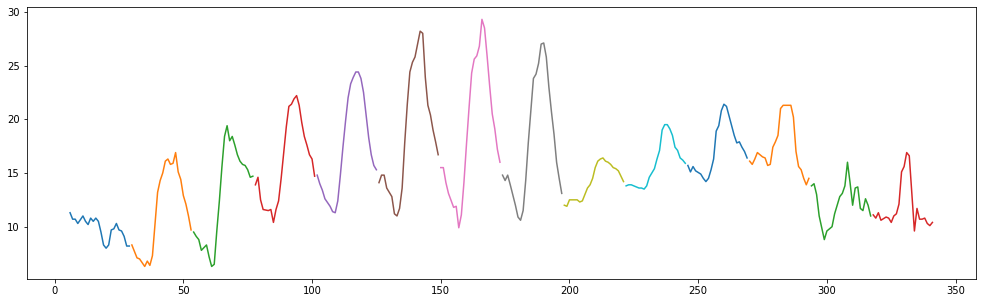

In [29]:
dfs.groupby('Day')['T'].plot(figsize=(17,5))
plt.autoscale

Trimming the dataset and converting it into a Time-series

In [30]:
dfs['Date']=dfs['Date'].astype(str)
dfs.loc[:,'Date'] = pd.to_datetime(df.Date.astype(str)+' '+dfs.Time.astype(str),format='%Y-%m-%d %H.%M.%S')
dfs1 = dfs
dfs.index = dfs.Date
dfs=dfs[['T']]
dfs.head()

,T
Date,
2004-03-11 00:00:00,11.3
2004-03-11 01:00:00,10.7
2004-03-11 02:00:00,10.7
2004-03-11 03:00:00,10.3
2004-03-11 05:00:00,11.0


### Performing Seasonal-Decomposition
Giving a period of 24(hours in a day) and splitting the data into Seasonal, Trend and Residual components.
Trend being the overall direction of the data.
Seasonality is a periodic component.
Residual are random fluctuations almost similar to noise.

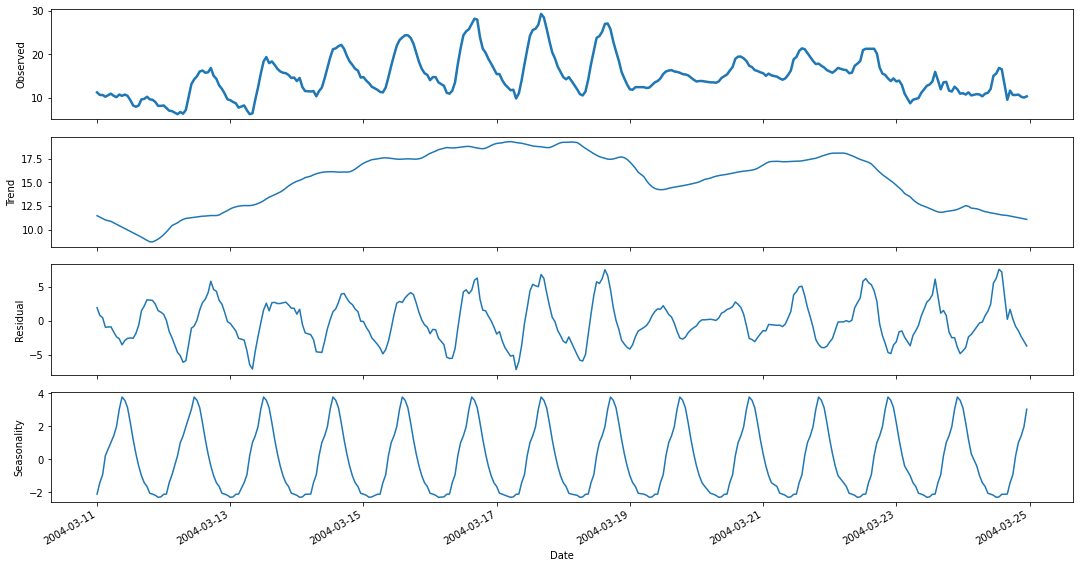

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(dfs['T'],period=24,extrapolate_trend=1)
fig, (ax0,ax1,ax2,ax3) = plt.subplots(4,1, figsize=(15,8), sharex=True)
ax1.set_ylabel('Trend')
ax2.set_ylabel('Residual')
ax3.set_ylabel('Seasonality')
ax0.set_ylabel('Observed')
decompose_data.observed.plot(ax=ax0,linewidth=2.5)
decompose_data.trend.plot(ax=ax1)
decompose_data.resid.plot(ax=ax2)
decompose_data.seasonal.plot(ax=ax3)
plt.tight_layout()


The dataset would be either additive or multiplicative. Through the trend of the graph we can conclude that it's additive and this can be verified by adding up all the components and plotting it along with the original curve(We can see that it perfectly overlaps) 
<h4><center>Observed = Seasonality + Trend + Residual</center></h4>

<AxesSubplot:xlabel='Date'>

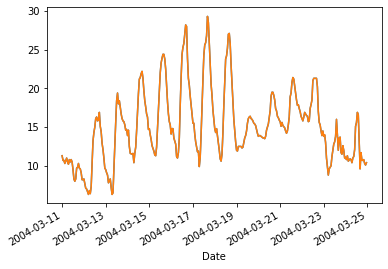

In [32]:
y = decompose_data.trend+decompose_data.resid+decompose_data.seasonal
ax = dfs['T'].plot()
y.plot(ax=ax)

In [33]:
dfs1['Trend'] = decompose_data.trend;
dfs1['Residual'] = decompose_data.resid;
dfs1['Seasonality'] = decompose_data.seasonal;
dfs1['Temperature'] = dfs1[['T']]
dfs1= dfs1.reset_index(drop=True)

Repeating the same process here and seperating the dependent(target values) and independent columns

In [34]:
X_1, X_2 = dfs1[(mask:=df1['Day'] <= 17)].copy(), dfs1[~mask].copy()
c = X_1.columns.tolist()[4:]
Train = X_1[c]
Test = X_2[c]

In [35]:
x_train = Train[['Day','Hour']]
x_test =  Test[['Day','Hour']]

y_test =  Test[['Trend','Residual','Seasonality']]
y_train = Train[['Trend','Residual','Seasonality']]

### Model Implementation 

In [36]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
UV = x_test['Day'].unique()
temp = 0;
result =[]

for i in UV:
    model1 = MultiOutputRegressor(xgb.XGBRegressor()) 
    model1.fit(x_train,y_train)
    testx = x_test[x_test["Day"] == i]
    testy = y_test[temp:temp+len(testx)]
    test1 = testx.to_numpy()
    x_train = x_train.append(testx, ignore_index=True)
    y_train = y_train.append(testy, ignore_index=True)
    resultx = model1.predict(test1)
    result.append(resultx)
    temp += len(testx)
    
print(result[0])

[[19.108467   -1.9676546  -1.6443149 ]
 [19.146328   -1.5988997  -2.04373   ]
 [19.179193   -2.9766798  -2.1003683 ]
 [19.247314   -3.978111   -2.1759465 ]
 [19.298546   -5.204582   -2.2948709 ]
 [19.26488    -5.1022515  -2.260309  ]
 [19.20881    -7.1844172  -2.1211867 ]
 [19.16785    -5.9723115  -2.088352  ]
 [19.127483   -3.6335807  -1.4163797 ]
 [19.061987   -0.4183909  -0.9190703 ]
 [18.986263    1.8795424   0.22498758]
 [18.901684    4.3924284   1.014006  ]
 [18.842678    5.330592    1.4122542 ]
 [18.804628    5.1130743   1.9820633 ]
 [18.788694    4.9969463   3.0326686 ]
 [18.751356    6.77023     3.7669067 ]
 [18.71381     6.2280617   3.566783  ]
 [18.669518    4.0977745   3.1228359 ]
 [18.675545    2.2181792   2.198175  ]
 [18.77283     0.53066486  1.2121547 ]
 [18.920698   -0.15978208  0.33837327]
 [19.060467   -1.4587396  -0.4029318 ]
 [19.180065   -2.1934123  -0.9923656 ]]


In [37]:
t_predicted =[]
r_predicted =[]
s_predicted =[]
y_predicted =[]
for j in result:
    for i in j:
        t_predicted.append(i[0])
        r_predicted.append(i[1])
        s_predicted.append(i[2])
        y_predicted.append(i[0]+i[1]+i[2])

Comparing all the three components and also the summation of these with the original Temperature
### Analysing the new Predicted values

In [38]:
dfs2 = Test;
dfs2['Trend(Predicted)'] = t_predicted
dfs2['Residual(Predicted)'] = r_predicted
dfs2['Seasonality(Predicted)'] = s_predicted
dfs2['Temperature(New)'] = y_predicted
dfs2['Error(New)'] = dfs2['Temperature(New)']-dfs2['Temperature']
dfs2.head()

,Day,Hour,Trend,Residual,Seasonality,Temperature,Trend(Predicted),Residual(Predicted),Seasonality(Predicted),Temperature(New),Error(New)
160,18,0,19.235417,-3.024569,-1.410848,14.8,19.108467,-1.967655,-1.644315,15.496497,0.696497
161,18,1,19.225000,-3.284024,-1.640976,14.3,19.146328,-1.598900,-2.043730,15.503698,1.203698
162,18,2,19.239583,-2.391396,-2.048188,14.8,19.179193,-2.976680,-2.100368,14.102146,-0.697854
163,18,3,19.268750,-3.267518,-2.101232,13.9,19.247314,-3.978111,-2.175946,13.093257,-0.806743
164,18,5,19.202083,-5.029537,-2.172547,12.0,19.298546,-5.204582,-2.294871,11.799093,-0.200907


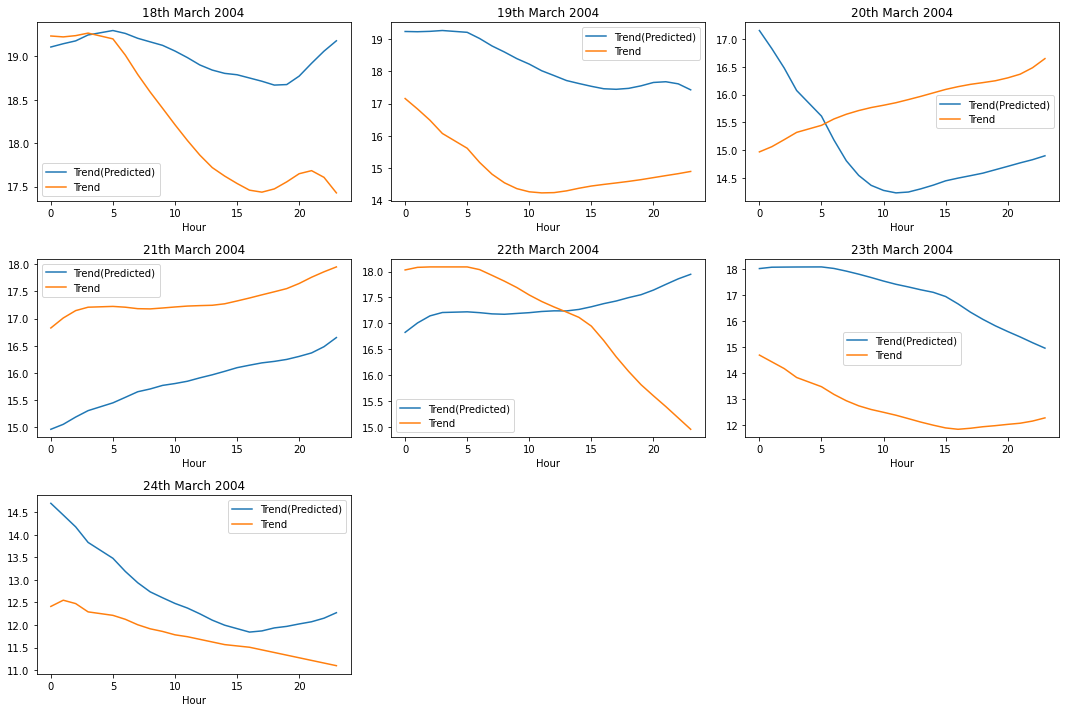

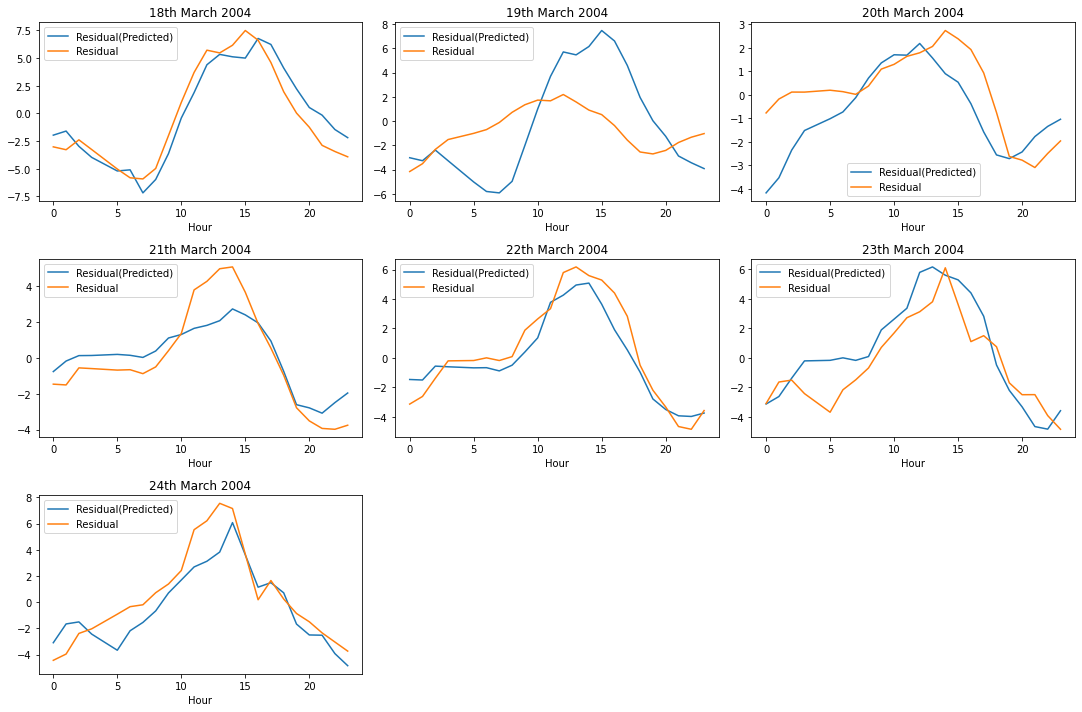

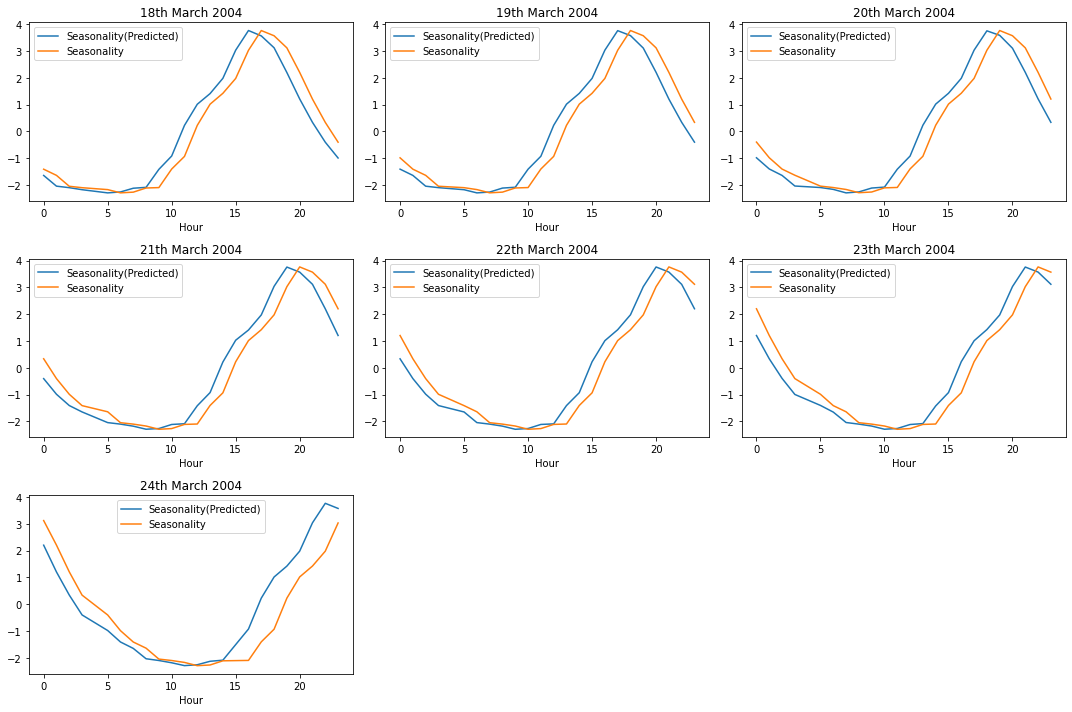

In [39]:
fig = plt.figure(figsize=(15, 10))
for i in range(0,7):
    ax = fig.add_subplot(3,3,i+1)
    dfs2[dfs2['Day']==18+i].plot('Hour',['Trend(Predicted)','Trend'],ax=ax)
    plt.title('%dth March 2004' % (18+i))
    plt.tight_layout()

    
fig = plt.figure(figsize=(15, 10))
for i in range(0,7):
    ax = fig.add_subplot(3,3,i+1)
    dfs2[dfs2['Day']==18+i].plot('Hour',['Residual(Predicted)','Residual'],ax=ax)
    plt.title('%dth March 2004' % (18+i))
    plt.tight_layout()
    
    
fig = plt.figure(figsize=(15, 10))
for i in range(0,7):
    ax = fig.add_subplot(3,3,i+1)
    dfs2[dfs2['Day']==18+i].plot('Hour',['Seasonality(Predicted)','Seasonality'],ax=ax)
    plt.title('%dth March 2004' % (18+i))
    plt.tight_layout()


As we can see Trend again takes a hit! Whereas the rest are quite predictable and have been almost accurate
### MAPE Calculation 

In [40]:
MAPE_DT=[]
for i in range(18,25):
    dfx=dfs2['Temperature'].loc[(dfs2['Day'] == i)]
    dfy=abs(dfs2['Error(New)'].loc[(dfs2['Day'] == i)])
    dfz=dfy.div(dfx);
    MAPE_DT.append(dfz.mean())

In [41]:
for i in range(0,len(MAPE_DT)):
    print("MAPE of T in %dth day: %s" % ((i+18),MAPEt[i]))

MAPE of T in 18th day: 0.11806801788399722
MAPE of T in 19th day: 0.25201352976406255
MAPE of T in 20th day: 0.1425698664991337
MAPE of T in 21th day: 0.1090814752619842
MAPE of T in 22th day: 0.12647537943125992
MAPE of T in 23th day: 0.42052674701332565
MAPE of T in 24th day: 0.18724052801552765


In [42]:
print('Average MAPE of T Concentration', np.mean(MAPE_DT))

Average MAPE of T Concentration 0.17204703733520596


We have reduced the MAPE from 19.34% to 17.20% through this approach. We also tried the same on CO(Conc) but it resulted in negligible difference.

### Presentation of Final Results

In [43]:
index = dfs1[ (dfs1["CO(GT)"] < 0)].index
dfs2.drop(index, inplace=True)
dfs2= dfs2.reset_index(drop=True)

In [44]:
print(dfs2.shape,df2.shape)

(160, 11) (160, 8)


In [48]:
df2 = df2[["Day","Hour","CO(GT)","CO(GT) Predicted","CO(GT) Error","T","T Predicted","T Error"]]
df2.round({"CO(GT)":1, "T":1})
df2['T_New Predicted'] = dfs2['Temperature(New)']
df2['T_New Error'] = dfs2['Error(New)']

Displaying all values to CO Concentration in shades of blue and Temperatures in shades of green.
<b>Dataframe visualization might be inverted in Dark Mode.</b> Kindly uncomment this section, if so

In [55]:
#df2.style.set_properties()

In [47]:
def highlight_cols(x):
    df = x.copy()
    df.loc[:, :] = 'color: black'
    df[["CO(GT) Predicted","CO(GT) Error"]] = 'background-color: #b4d2fd'
    df[["CO(GT)"]] = 'background-color: #26b5d9'
    df[["T"]] = 'background-color: #00ffbb'
    df[["T Predicted","T Error"]] = 'background-color: #15f50a'
    df[["T_New Predicted","T_New Error"]] = 'background-color: #a0ff00'
    return df 
  
print("Highlighted DataFrame :")
display(df2.style.apply(highlight_cols, axis = None))


Highlighted DataFrame :


,Day,Hour,CO(GT),CO(GT) Predicted,CO(GT) Error,T,T Predicted,T Error,T_New Predicted,T_New Error
0,18,0,2.300000,2.110326,-0.189674,14.800000,16.177864,1.377864,15.496497,0.696497
1,18,1,1.400000,1.919442,0.519442,14.300000,16.098240,1.798240,15.503698,1.203698
2,18,2,1.000000,1.647127,0.647127,14.800000,15.417482,0.617482,14.102146,-0.697854
3,18,3,0.700000,1.393692,0.693692,13.900000,14.642238,0.742238,13.093257,-0.806743
4,18,5,0.600000,1.208716,0.608716,12.000000,14.319855,2.319855,11.799093,-0.200907
5,18,6,0.700000,1.208716,0.508716,10.900000,13.919968,3.019968,11.902319,1.002319
6,18,7,1.500000,1.642653,0.142653,10.600000,13.403366,2.803366,9.903206,-0.696794
7,18,8,4.700000,3.560461,-1.139539,11.500000,14.006867,2.506867,11.107187,-0.392813
8,18,9,6.600000,4.277819,-2.322181,14.300000,15.708034,1.408034,14.077522,-0.222478
9,18,10,4.500000,3.809210,-0.690790,17.800000,18.587807,0.787807,17.724525,-0.075475


<h4>Average MAPE of CO Concentration:     30.54693881578768 %</h4>
<h4>Average MAPE of Temperature:          19.37107919813272 %</h4>
<h4>Improved average MAPE of Temperature: 17.20470373352059 %</h4>


<h2><center>Thank You<center></h2>
